---
title: "Lollipop chart"
description: "Scrape play-by-play data and plot shot events as a lollipop chart, with the length of the stem indicating xG values"
author: "chicken"
date: "12/31/2025"
categories:
    - "tutorials"
image: charts/2025020612.png
lightbox: true
draft: false
---

## **Intro**

Use the `chickenstats` library to scrape play-by-play data and plot shot events as a lollipop chart,
with the length of the stem indicating the predicted goal value. 

Parts of this tutorial are optional and will be clearly marked as such. For help, or any questions,
please don't hesitate to reach out to [chicken@chickenandstats.com](mailto:chicken@chickenandstats.com) or
[@chickenandstats.com](https://bsky.app/profile/chickenandstats.com) on Blue Sky.


---

![](./charts/2025020612.png)

---

## **Housekeeping**

### Import dependencies

Import the dependencies we'll need for the guide

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import polars as pl
from matplotlib.lines import Line2D

from chickenstats.chicken_nhl import Scraper, Season
from chickenstats.chicken_nhl._helpers import charts_directory
from chickenstats.chicken_nhl.team import NHL_COLORS

### Polars options

Sets different polars options. This cell is optional

In [ ]:
pl.Config.set_tbl_cols(-1)

polars.config.Config

### Folder structure

In [ ]:
charts_directory()

### Chickenstats matplotlib style

chickenstats.utilities includes a custom style package - this activates it. This cell is also optional

In [ ]:
plt.style.use("chickenstats")

---

## **Scrape data**

### Schedule, standings, and team names

Scrape the schedule and standings using the `Season` object. Then, create some name dictionaries for convenience later

In [ ]:
season = Season(2025)

In [ ]:
schedule = season.schedule()  # Progress bar renders poorly in ipynb to md conversions

Output()

In [ ]:
standings = season.standings  # Standings as a dataframe for the team name dictionaries

In [ ]:
team_names = standings.sort(by="team_name", descending=False)["team_name"].str.to_uppercase().to_list()
team_codes = standings.sort(by="team_name", descending=False)["team"].str.to_uppercase().to_list()
team_names_dict = dict(zip(team_codes, team_names, strict=False))  # These are helpful for later

### Game IDs

Select the team and games to plot. The default is the most recent game for the Nashville Predators :).
Feel free to change for your chosen team code 

In [ ]:
team = "NSH"

conditions = (pl.col("game_state") == "OFF", ((pl.col("home_team") == team) | (pl.col("away_team") == team)))

game_ids = schedule.filter(conditions)["game_id"].unique().to_list()
game_id = game_ids[-1]

### Play-by-play

Scrape the play-by-play data for the chosen game ID. First instantiate the `Scraper` object,
then call the play_by_play attribute

In [ ]:
scraper = Scraper(game_id)

In [ ]:
pbp = scraper.play_by_play

Output()

---

## **Plotting the lollipop chart**

### Helper functions

This helper function formats numbers for the x-axis

In [ ]:
def numfmt(x: int, pos) -> str:
    """Function to convert the game-time values as minutes, then format them for the x-axis.

    Used within the matplotlib FuncFormatter.

    Parameters:
        x (int):
            The game time, in seconds, to convert.
        pos:
            Required by the FuncFormatter

    """
    s = str(int(x / 60))
    return s

### Plotting function

This function plots the actual lollipop chart. You can select the strength states, while the team parameter
determines which team is in the upper portion of the chart. 

Strength state options include:
* 5v5
* even strength
* special teams (i.e., powerplay and shorthanded)
* empty net
* all strength states

In [ ]:
def plot_lollipop(data: pl.DataFrame, ax: plt.axes, team: str | None = None, strengths: str | None = None) -> plt.axes:
    """Function to plot the lollipop chart, with the given in the upper portion.

    Parameters:
        data (pl.DataFrame):
            Play-by-play data for a single game scraped using the chickenstats package.
        ax (plt.axes):
            The axes on which to plot the lollipop chart.
        team (str):
            Three-letter team code to determine which team is in the upper portion of the chart.
            Default is the home team
        strengths (str):
            The strength states to include in the chart. Default is 5v5

    """
    strengths_dict = {
        "5v5": {"name": "5v5", "list": ["5v5"]},
        "even": {"name": "even_strength", "list": ["5v5", "4v4", "3v3"]},
        "special": {"name": "special_teams", "list": ["5v4", "5v3", "4v5", "3v5"]},
        "empty": {"name": "empty_net", "list": ["Ev5", "Ev4", "Ev3", "5vE", "4vE", "3vE"]},
        "all": {"name": "all", "list": ["5v5", "4v4", "3v3", "5v4", "5v3", "4v5", "3v5"]},
    }

    if not strengths:
        strengths = "5v5"

    strengths = strengths_dict[strengths]

    strengths_list = strengths["list"]

    condition = pl.col("strength_state").is_in(strengths_list)

    df = data.filter(condition)

    if not team:
        team = df.item(0, "home_team")

    ax.set_ylim(-1.05, 1.05)
    # ax.axhline(y = 0, lw=1, alpha=.8)
    ax.axhline(y=0.5, lw=1, zorder=-1, alpha=0.25)
    ax.axhline(y=1, lw=1, zorder=-1, alpha=0.25)
    ax.axhline(y=-0.5, lw=1, zorder=-1, alpha=0.25)
    ax.axhline(y=-1, lw=1, zorder=-1, alpha=0.25)
    ax.set_yticks([1, 0.5, 0, -0.5, -1], labels=[1, 0.5, 0, 0.5, 1])

    max_game_seconds = data["game_seconds"].max()

    ax.set_xlim(-5, max_game_seconds + 35)
    ax.spines.bottom.set_position("zero")

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1200))

    xfmt = ticker.FuncFormatter(numfmt)
    ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(60))

    ax.set_ylabel("EXPECTED GOAL VALUE", fontsize=8)

    events = ["GOAL", "SHOT", "MISS"]

    conditions = (pl.col("event_team") == team, pl.col("event").is_in(events))

    plot_data = df.filter(conditions)

    team_post = 0

    for play in plot_data.to_dicts():
        colors = NHL_COLORS[play["event_team"]]

        marker = "o"

        facecolor = colors[play["event"]]
        edgecolor = colors[play["event"]]

        if play["event"] == "GOAL":
            z_order = 3
            alpha = 1
            hatch = ""
            edgecolor = colors["SHOT"]

        else:
            hatch = ""
            alpha = 0.65
            z_order = 2

        if play["event"] == "MISS":
            if "POST" in play["description"]:
                team_post += 1
                hatch = "////////"

            edgecolor = colors["SHOT"]

        ax.scatter(
            [play["game_seconds"]],
            [play["pred_goal"]],
            marker=marker,
            s=60,
            color=facecolor,
            lw=1.15,
            ec=edgecolor,
            zorder=z_order,
            hatch=hatch,
            alpha=alpha,
        )
        if play["event"] == "MISS":
            edgecolor = colors["MISS"]

        ax.plot(
            [play["game_seconds"], play["game_seconds"]],
            [0, play["pred_goal"]],
            lw=1.85,
            color=edgecolor,
            zorder=0,
            alpha=0.65,
        )

    conditions = (pl.col("event_team") != team, pl.col("event").is_in(events))

    plot_data = df.filter(conditions)

    not_team_post = 0

    for play in plot_data.to_dicts():
        colors = NHL_COLORS[play["event_team"]]

        marker = "o"

        facecolor = colors[play["event"]]
        edgecolor = colors[play["event"]]

        if play["event"] == "GOAL":
            z_order = 3
            alpha = 1
            edgecolor = colors["SHOT"]

        else:
            alpha = 0.65
            z_order = 2

        if play["event"] == "MISS":
            if "POST" in play["description"]:
                hatch = "////////"

                not_team_post += 1

            edgecolor = colors["SHOT"]

        ax.scatter(
            [play["game_seconds"]],
            [play["pred_goal"] * -1],
            marker=marker,
            s=60,
            color=facecolor,
            lw=1.15,
            ec=edgecolor,
            zorder=z_order,
            alpha=alpha,
        )

        if play["event"] == "MISS":
            edgecolor = colors["MISS"]

        ax.plot(
            [play["game_seconds"], play["game_seconds"]],
            [0, play["pred_goal"] * -1],
            lw=1.85,
            color=edgecolor,
            zorder=0,
            alpha=0.65,
        )

    not_team = df.filter(pl.col("event_team") != team, pl.col("event_team").is_not_null()).item(0, "event_team")

    # legends

    legend_handles = []

    for event in ["GOAL", "SHOT", "MISS"]:
        colors = NHL_COLORS[team]

        linecolor = colors["SHOT"]
        facecolor = colors[event]

        legend_handle = Line2D(
            [],
            [],
            color=linecolor,
            markeredgecolor=linecolor,
            markerfacecolor=facecolor,
            marker=marker,
            markersize=5,
            label=event,
            alpha=0.65,
        )

        legend_handles.append(legend_handle)

    legend1 = ax.legend(
        handles=legend_handles,
        loc=(0.01, 0.8575),
        ncols=len(legend_handles),
        fontsize="small",
        title=team_names_dict[team],
        title_fontsize="small",
    )
    ax.add_artist(legend1)

    legend_handles = []

    for event in ["GOAL", "SHOT", "MISS"]:
        colors = NHL_COLORS[not_team]

        linecolor = colors["SHOT"]
        facecolor = colors[event]

        legend_handle = Line2D(
            [],
            [],
            color=linecolor,
            markeredgecolor=linecolor,
            markerfacecolor=facecolor,
            marker=marker,
            markersize=5,
            label=event,
            alpha=0.65,
        )

        legend_handles.append(legend_handle)

    legend2 = ax.legend(
        handles=legend_handles,
        loc=(0.01, 0.0575),
        ncols=len(legend_handles),
        fontsize="small",
        title=team_names_dict[not_team],
        title_fontsize="small",
    )
    ax.add_artist(legend2)

    team_df = df.filter(pl.col("event_team") == team)
    team_g = team_df["goal"].sum()
    team_xg = team_df["pred_goal"].sum()

    not_team_df = df.filter(pl.col("event_team") != team)
    not_team_g = not_team_df["goal"].sum()
    not_team_xg = not_team_df["pred_goal"].sum()

    ax_title = f"{team_names_dict[team]} vs. {team_names_dict[not_team]}"
    ax.set_title(ax_title, ha="left", x=-0.055, y=1.06)

    strengths_name = strengths["name"].replace("_", " ").upper()
    score_subtitle = f"{team_g}G ({round(team_xg, 2)} xG) - {not_team_g}G ({round(not_team_xg, 2)} xG)"
    game_date = df.item(0, "game_date")

    ax_subtitle = f"{score_subtitle} | {strengths_name} |  {game_date}"
    ax.text(s=ax_subtitle, ha="left", x=-0.055, y=1.035, transform=ax.transAxes)

    attribution = "Viz @chickenandstats.com | xG model @chickenandstats.com"
    ax.text(s=attribution, ha="right", x=0.99, y=-0.05, transform=ax.transAxes, fontsize=8, fontstyle="italic")

    return ax

### Plot the lollipop chart

Plot the lollipop for your chosen team and strength state below.
To save the figure, ensure you have a charts folder in your working directory

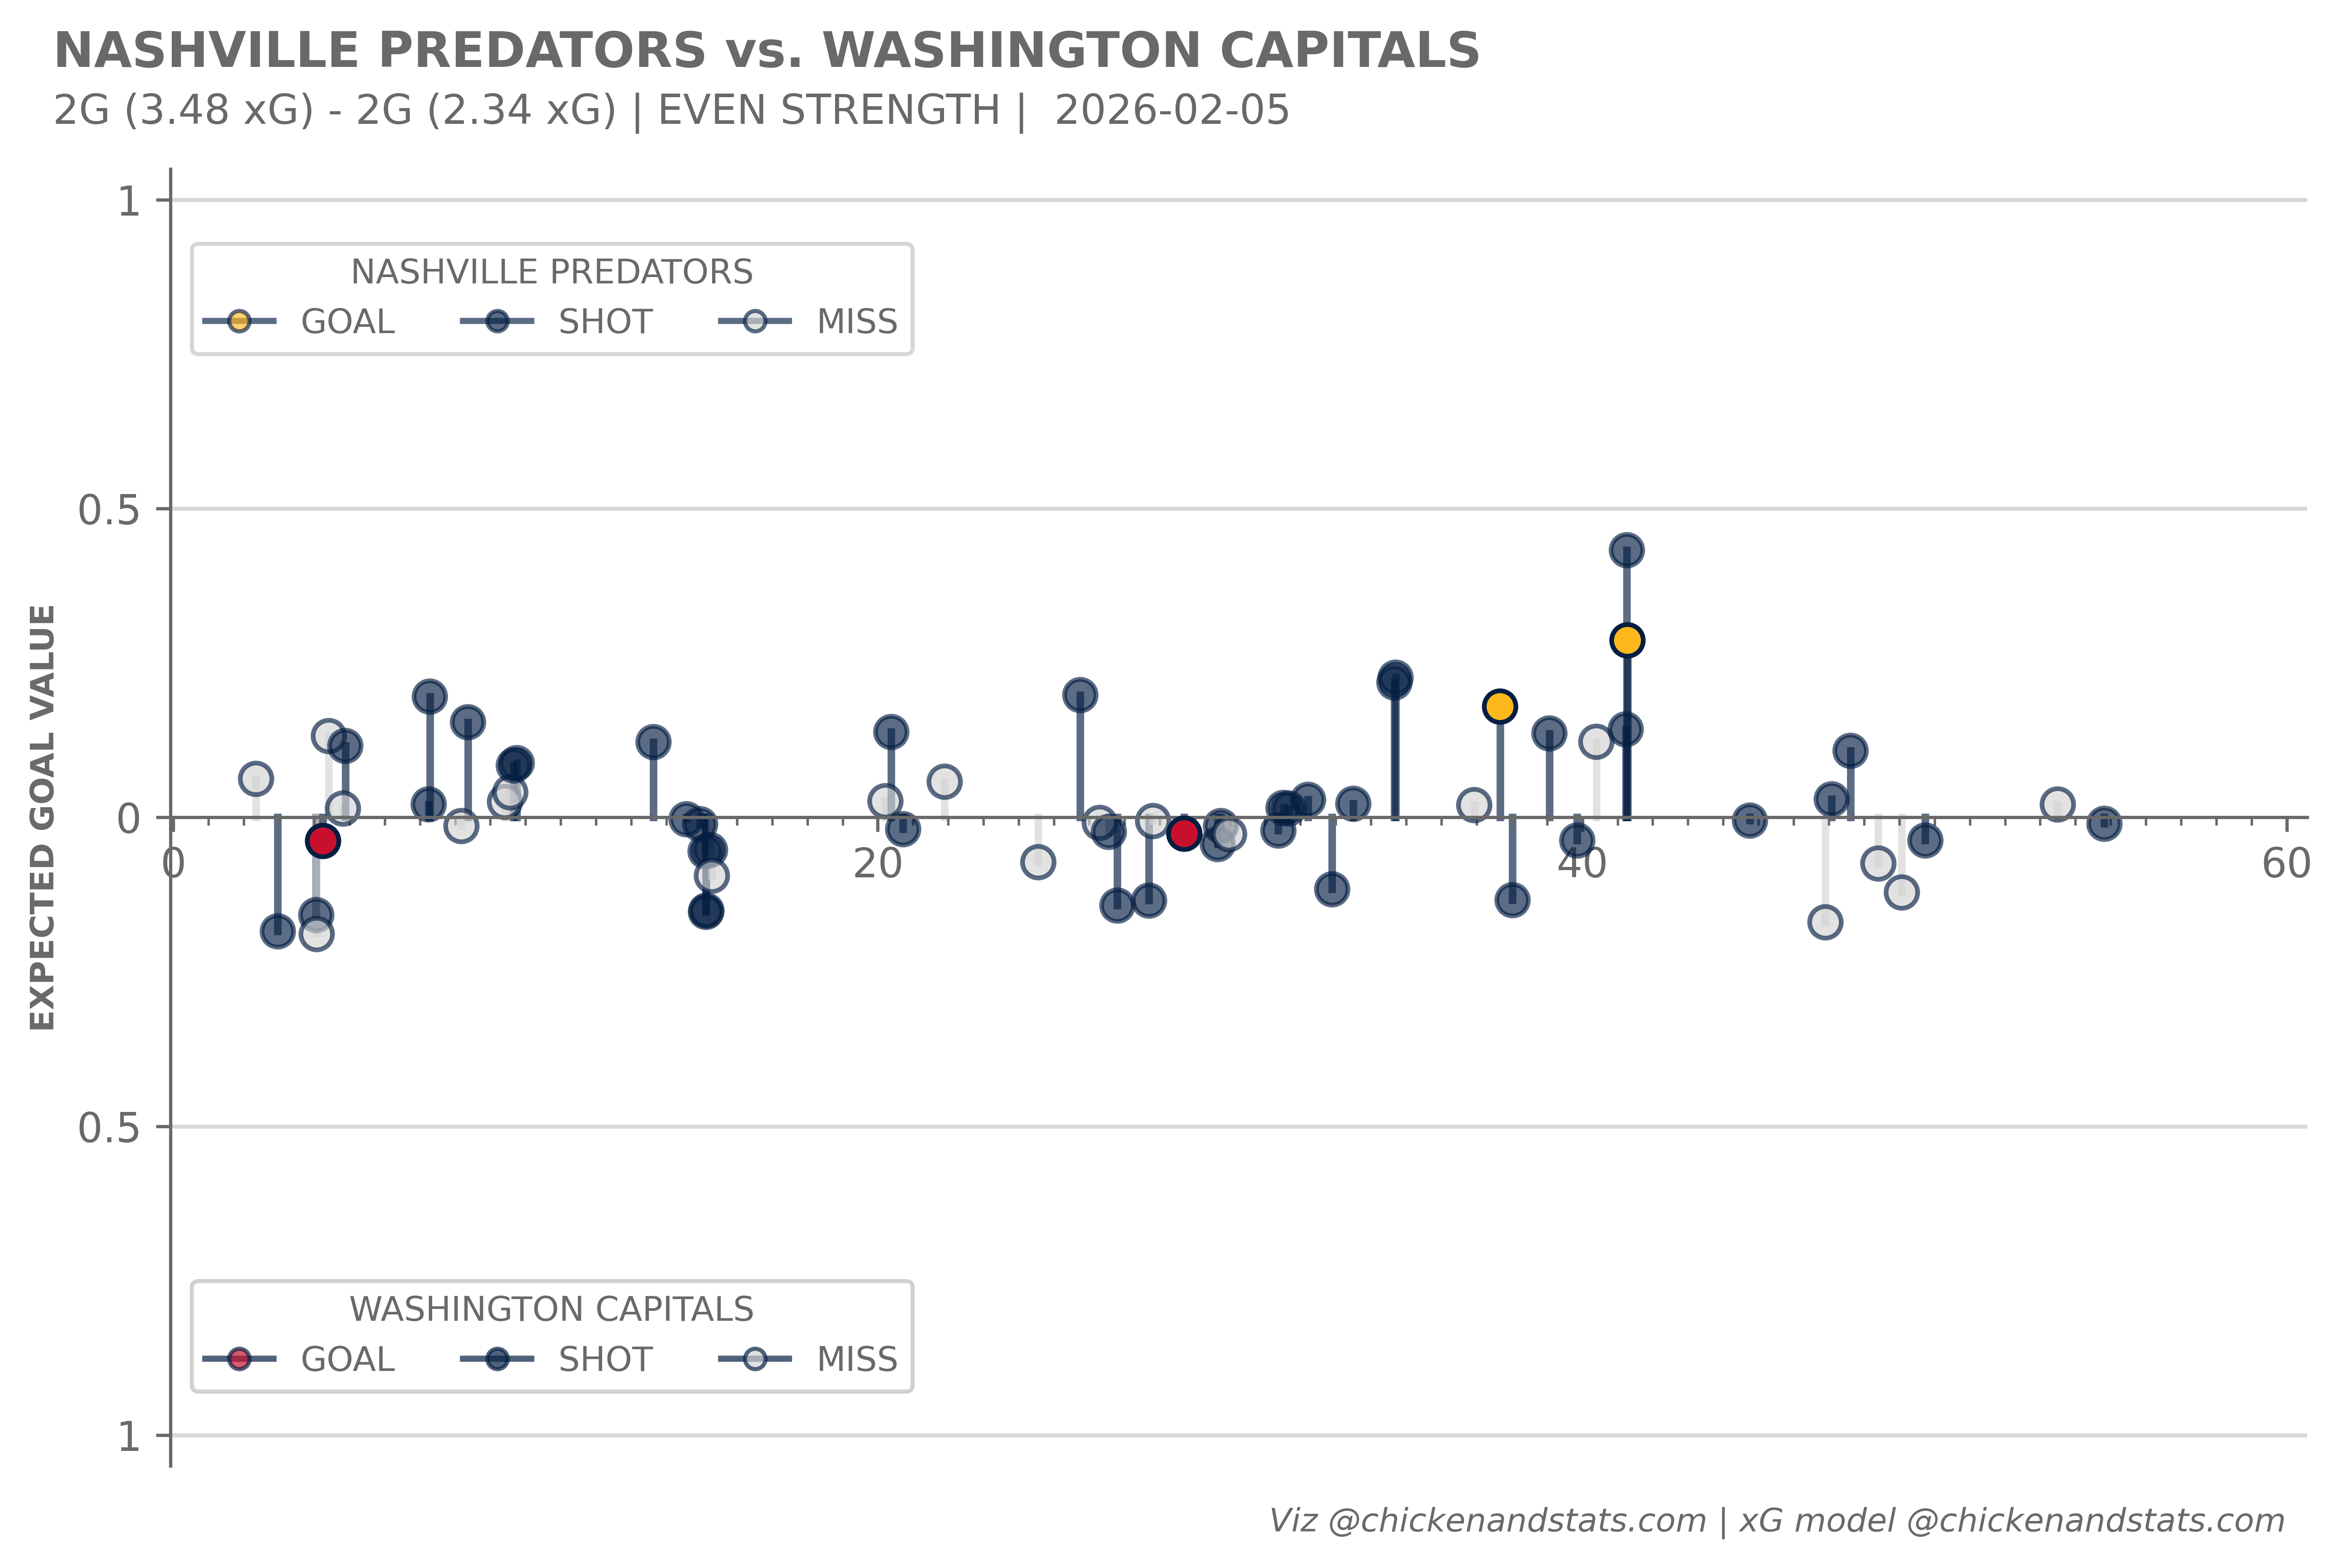

In [ ]:
fig, ax = plt.subplots(dpi=650, figsize=(8, 5))

fig.tight_layout()

ax = plot_lollipop(data=pbp, team=team, strengths="even", ax=ax)

fig.savefig(f"./charts/{game_id}.png", bbox_inches="tight", transparent=False)